In [16]:
  # Imports
import numpy as np
from numpy.lib.arraysetops import unique
from scipy.sparse import lil_matrix, csr_matrix, bmat
from scipy.sparse import linalg 
from scipy.sparse.linalg import spsolve

In [17]:
# Import repository
! rm -fr *
! git clone https://gitlab.com/jan.zeman4/d32mhm2_en.git tmp
! mv tmp/* . # copy to current directory
! rm -fr tmp/ # cleanup

Cloning into 'tmp'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 98 (delta 51), reused 50 (delta 23), pack-reused 0
Unpacking objects: 100% (98/98), done.


In [18]:
# Local functions
from show import show
from data import u_D_hmg 
from stima import stima3_hmg, flux3 

In [19]:
# Load all data
coordinates = np.loadtxt ( 'coordinates_hmg.dat', comments = '%' )
elements3 = np.loadtxt( 'elements3_hmg.dat', dtype = 'int', comments = '%' )
dirichlet = np.loadtxt( 'dirichlet_hmg.dat', dtype = 'int', comments = '%' )
# New data needed for homogenization
phases = np.loadtxt ( 'phases_hmg.dat', comments = '%' )
periodicity = np.loadtxt ( 'periodicity_hmg.dat', dtype = 'int', comments = '%' )

In [20]:
# delete first columns from coordinates, elements3, elements4, and neumann arrays
coordinates = np.delete( coordinates, 0, 1 )
elements3 = np.delete( elements3, 0, 1 )
dirichlet = np.delete( dirichlet, 0, 1 )
phases = np.delete( phases, 0, 1 )
periodicity = np.delete( periodicity, 0, 1 )

In [21]:
# setup matrices
FreeNodes = np.setdiff1d( range( coordinates.shape[0]), np.unique( dirichlet ) )
A = lil_matrix( np.zeros( (coordinates.shape[0], coordinates.shape[0]) ) ) 
b = np.zeros( (coordinates.shape[0], 1) )  
u = np.zeros( (coordinates.shape[0], 1) ) 

In [22]:
# stifness matrix is the standard one
for e in range( elements3.shape[0] ):
   A[ np.ix_( elements3[e, 0:3], elements3[e, 0:3] ) ] += stima3_hmg( coordinates[ elements3[e, 0:3], ], phases[ elements3[e, 3], ] )


Tying conditions are of the type

\begin{align}
\bf T  u = c 
\end{align}

where the entries of T are $\pm 1$ and $\bf c$ is a non-homogeneous RHS. In our problem, they should implement the conditions of the type

\begin{align}
\theta^i - \theta^j = {\bf E}^T ( {\bf y}^i - {\bf y}^j ) 
\end{align}

where $i$ and $j$ are the correspoding "periodic" nodes.

In [23]:
E = [ [1], [0] ]

# Prepare tying matrix T
T = np.zeros( (periodicity.shape[0], coordinates.shape[0]) )
c = np.zeros( (periodicity.shape[0], 1) )

for j in range( periodicity.shape[0] ):
  T[j, periodicity[j, :]] = [1, -1]
  c[j] = np.matmul( coordinates[ periodicity[j, 0], ] - coordinates[ periodicity[j, 1], ], E )

Dirichlet boundary conditions 
$$
{\bf \theta}^j = {\bf E}^T {\bf y}^j 
$$

In [24]:
# Implement Dirichlet boundary conditions
dirichlet = np.unique( dirichlet )

for j in range( dirichlet.shape[0] ):
  u[ dirichlet[j] ] = np.matmul( coordinates[ dirichlet[j] ], E)

\begin{align}
\begin{bmatrix}
{\bf A}_{FF} & {\bf A}_{FD} & {\bf T}^T \\
{\bf A}_{DF} & {\bf A}_{DD} & {\bf T}^T \\
{\bf T} & {\bf T} & \bf{0}
\end{bmatrix}  
\begin{bmatrix}
{\bf u}_F \\
\overline{\bf u}_D \\
{\boldsymbol \lambda} 
\end{bmatrix}
=
\begin{bmatrix}
{\bf 0} \\
{\bf R} \\
{\bf c} 
\end{bmatrix},
%
\end{align}

where $\overline{\bf u}_D$ represents the given non-uniform Dirchlet boundary conditions.


In [25]:
# Implement non-uniform Dirichlet BCs
b -= A*u # Implement the non-uniform Dirichlet BCs

A_hmg = bmat( [ [ A[ np.ix_( FreeNodes, FreeNodes) ], T[:, FreeNodes ].transpose() ], \
  [ T[:, FreeNodes ], None ] ] )
b_hmg = np.block( [ [ b[ FreeNodes, ] ], [ c ] ] )

u_hmg = spsolve( A_hmg.tocsr(), b_hmg ) # Solve the partitioned system

u[ (FreeNodes, 0) ] = u_hmg[ 0:FreeNodes.shape[0] ]

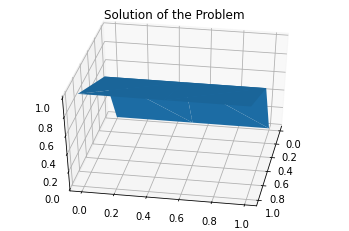

In [26]:
# Setup the partitioned system
show(elements3[:, 0:3], np.array([]), coordinates, u)

In [27]:
# Compute the average flux in the PUC
Q = np.zeros( (2, 1) ) # Average heat flux
A = 0. # Area of RVE

for j in range( elements3.shape[0] ): 
  Q_e, A_e = flux3( coordinates[ elements3[ j, 0:3], ], phases[ elements3[j, 3], ], \
                          u[ elements3[ j, 0:3 ], ], ) 
  Q += Q_e * A_e
  A += A_e

Q /= A # Normalize with respect to volume

# Output the result
print( Q )
print( A )

# Analytical formula for homogenization
c = 0.3 # Volume fraction for the first phase
print( 1./ ( c / phases[0, 0] + (1 - c) / phases[1, 0] ) )
print( c * phases[0, 2] + (1 - c ) * phases[1, 2])

[[4.54545455]
 [0.        ]]
0.9999999999999997
4.545454545454546
14.6
